# LLM from scratch

The goal is to code from scratch (using Pytorch) a Transformer, more precisely a GPT-like model (using a decoder-only architecture). See discussion at the end for what's missing to build a full blown LLM.

Credits and references: 
* I strongly recommend Andrej Karpathy's lectures, videos, and repositories, in particular
https://github.com/karpathy/nn-zero-to-hero
https://github.com/karpathy/makemore
* A fantastic reference which goes in a lot more depth, is Sebastian Raschka's book and codebase:
https://github.com/rasbt/LLMs-from-scratch
Most illustrations below are from the book.

Full notebook: https://github.com/nathanael-fijalkow/LLM_from_scratch

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import trange

What we will do here: train a generative model with Bob Dylan's songs. The goal is to generate more songs!

In [2]:
batch_size = 64 # number of sequences processed in parallel
n_token = 512 # number of tokens (used for the tokenizer)

## Part 1: Playing with the dataset

Let's download the dataset.

In [3]:
from datasets import load_dataset
ds = load_dataset("huggingartists/bob-dylan", split="train")
ds = ds.train_test_split(test_size=0.1)

In [4]:
ds

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 2016
    })
    test: Dataset({
        features: ['text'],
        num_rows: 225
    })
})

In [5]:
ds["train"][12]

{'text': 'If today were not an endless highway\nIf tonight were not a crooked trail\nIf tomorrow were not such a long time\nThen the lonesome would mean nothing to me at all\nAnd if my own true love were only waiting for me\nAnd if I could hear her heart softly pounding\nIf only she were lying by me\nThen I could sleep in my bed once again\nI cant see my reflection in the water\nCant speak the sounds that show no pain\nI cant hear the echo\nCant remember the sound of my own name\nAnd if my own true love were only waiting for me\nAnd if I could hear her heart softly pounding\nIf only she were lying by me\nThen I could sleep in my bed once again\nTheres beauty in the silver, singing river\nTheres beauty in the sunrise in the sky\nNone of these can match the beauty\nThat I remember in my true loves eyes\nAnd if my own true love were only waiting for me\nAnd if I could hear her heart softly pounding\nIf only she were lying by me\nThen I could sleep in my bed once again'}

## Part 2: Word-level tokenizer

The science of decomposing a text into tokens is a complicated one. Here we use `minbpe`, which implements the Byte Pair Encoding (BPE) algorithm commonly used in LLM tokenization.

In [6]:
from minbpe.minbpe import RegexTokenizer

In [7]:
partial_text = "\n".join(ds["train"][x]["text"] for x in range(20))
partial_text[502:600]

'to me my country pie\nI wont throw it up in anybodys face\nShake me up that old peach tree\nLittle Ja'

In [8]:
tokenizer = RegexTokenizer()
tokenizer.train(partial_text, 512, verbose=False)

We encode the entire text datasets and store them into `torch.Tensor`.

In [9]:
train_data = "\n".join(ds["train"][x]["text"] for x in range(ds["train"].num_rows))
test_data = "\n".join(ds["test"][x]["text"] for x in range(ds["test"].num_rows))

train_data = torch.tensor(tokenizer.encode(train_data), dtype=torch.long)
test_data = torch.tensor(tokenizer.encode(test_data), dtype=torch.long)

train_data.shape, train_data[:50]

(torch.Size([1240283]),
 tensor([ 74, 343, 400, 354, 502,  97, 120, 503, 104, 344,  32,  74, 111, 101,
          10, 504, 299, 115, 428, 264, 290, 111, 103, 115, 257, 319, 413, 311,
         505, 280, 101,  10, 406, 301,  44, 289, 104, 297,  10,  76, 111, 291,
         320, 414, 441, 386, 285, 325,  10,  76]))

In [10]:
test = "hello world"
test_encoded = tokenizer.encode(test)
test_encoded, [tokenizer.decode([x]) for x in test_encoded], tokenizer.decode(test_encoded)

([257, 265, 111, 268, 300, 310],
 ['he', 'll', 'o', ' w', 'or', 'ld'],
 'hello world')

The longest tokens:

In [11]:
token_list = sorted([tokenizer.decode([x]) for x in range(n_token)], 
                    key=len, 
                    reverse=True)
token_list[:20]

[' watchtow',
 ' rolling',
 ' played',
 ' friend',
 ' watcht',
 ' gonna',
 ' knick',
 '-knack',
 ' every',
 ' going',
 ' there',
 ' along',
 ' watch',
 ' that',
 ' your',
 ' with',
 ' play',
 ' gonn',
 ' time',
 ' down']

## Part 3: Evaluating and training with batches

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Our models will take as input `context_length` many tokens and produce the next token.

In [13]:
context_length_test = 64
ix = torch.randint(len(train_data) - context_length_test, (1,))
sample = train_data[ix:ix+context_length_test+1]
sample_list = sample.tolist()
print("Input: ", sample_list[:-1], 
      "\nTarget: ", sample_list[-1])
print("\nHuman version:\nInput: ", tokenizer.decode(sample_list[:-1]), 
      "\nTarget: ", tokenizer.decode([sample_list[-1]]))

Input:  [101, 384, 356, 115, 271, 10, 369, 284, 109, 404, 114, 339, 10, 406, 44, 335, 115, 263, 111, 290, 318, 44, 263, 111, 270, 101, 102, 321, 115, 388, 10, 418, 115, 32, 91, 63, 125, 44, 284, 263, 119, 101, 316, 293, 287, 277, 422, 10, 360, 467, 263, 257, 115, 380, 288, 264, 270, 101, 272, 104, 326, 301, 10, 87] 
Target:  340

Human version:
Input:  e time loser
But Im alright
Oh, its so high, so defensive
Its [?}, I swear this gal
You know shes gonna be the death of me
W 
Target:  ell


In [ ]:
def get_batch(split, context_length):
    data = train_data if split == 'train' else test_data
    ix = torch.randint(len(data) - context_length - 1, (batch_size,))
    X = torch.stack([data[i:i+context_length] for i in ix])
    Y = torch.stack([data[i+1:i+context_length+1] for i in ix])
    return X, Y

X,Y = get_batch("train", 8)
X.shape, Y.shape

We illustrate below how the cross entropy loss is computed along batches (as the mean over the batches). The same works for most functions in Pytorch, which means that writing code for batches is almost as easy as without!

In [14]:
batch_size_test = 3
n_token_test = 5

logits = torch.randn(batch_size_test, n_token_test)
target = torch.randint(n_token_test, (batch_size_test,), dtype=torch.int64)
loss = F.cross_entropy(logits, target)
print("logits: ", logits, "\ntarget: ", target, "\nloss: ", loss.item())

logits:  tensor([[ 1.4600, -0.5697,  0.9108, -0.1985, -0.7940],
        [-0.6241, -1.0471,  2.4603,  1.9540, -0.3306],
        [ 0.4363,  0.6075, -1.5104,  0.5921, -1.3629]]) 
target:  tensor([3, 3, 4]) 
loss:  2.170518636703491


Let us write the boilerplate code for models.

In [15]:
def estimate_loss(model, eval_iters):
    out = {}
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, model.context_length)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    return out

The code below for training is very generic. We iterate a number of times:
* sample data `(X,Y)` (we write `(X,Y)` for batches, and `(x,y)` for a single datapoint) 
* forward pass: compute the loss on `(X,Y)`
* reset the gradients for all parameters
* backward pass: compute the gradients, using `loss.backward()`
* run one step of gradient descent (here, the refined Adam optimizer, which adapts the learning rate)

When doing the forward pass, Pytorch creates computation graphs which are then used to compute the gradients.

In [16]:
def train(model, n_iterations, learning_rate, eval_interval, eval_iters):
    # create a PyTorch optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    for iter in range(n_iterations):
        # every once in a while evaluate the loss on train and validation sets
        if iter % eval_interval == 0 or iter == n_iterations - 1:
            with torch.no_grad():
                losses = estimate_loss(model, eval_iters)
            print(f"step {iter}: train loss {losses['train']:.4f}, validation loss {losses['val']:.4f}")

        X,Y = get_batch("train", model.context_length)
        X.to(device)
        Y.to(device)
        _, loss = model(X, Y)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

## Part 4: A Multi Layer Perceptron (MLP) model

We essentially implement the model from the paper "**A Neural Probabilistic Language Model**" by Bengio et al from 2003.

The first component is an `Embedding` layer: this is simply a lookup table, as illustrated below. It maps every token to a vector in fixed dimension. Since the dimension is much smaller than the number of tokens, intuitively the embedding layer will have to map similar tokens to similar vectors.

In [17]:
n_token_test = 3
n_embed_test = 4

embedding = torch.nn.Embedding(n_token_test, n_embed_test)
print("Weights of the embedding:\n", embedding.weight)
print("Result of embedding token number 1:\n", embedding(torch.tensor([1])))

Weights of the embedding:
 Parameter containing:
tensor([[-1.0390, -0.9249,  0.4335, -0.5309],
        [ 0.5942,  0.5029, -1.5714, -0.3394],
        [-0.7615,  0.0230, -0.6510, -0.7321]], requires_grad=True)
Result of embedding token number 1:
 tensor([[ 0.5942,  0.5029, -1.5714, -0.3394]], grad_fn=<EmbeddingBackward0>)


Let us describe how the model works. 

Recall that a datapoint is a tensor `x` of size `context_length`. Each of the `context_length` token is embedded, yielding a tensor of dimension `n_embed`. The resulting embeddings are concatenated to form a tensor of dimension `context_length * n_embed`, and then fed into a standard feed forward network. This is illustrated below (minus the network), with batches.

In [18]:
batch_size_test = 2
context_length_test = 3
n_token_test = 4
n_embed_test = 5

blank_token_test = n_token_test

idx = torch.randint(high = n_token_test, size = (batch_size_test, context_length_test))
print("Input tokens:\n", idx)
embedding = torch.nn.Embedding(n_token_test + 1, n_embed_test)
print("Weights of the embedding:\n", embedding.weight)

print("*******************\n")

x = embedding(idx)
x.shape, x

Input tokens:
 tensor([[2, 2, 1],
        [1, 1, 2]])
Weights of the embedding:
 Parameter containing:
tensor([[ 1.7433, -0.9162, -0.6442,  1.5750,  0.3102],
        [-0.0613, -0.2082, -0.6025,  0.4985,  0.0975],
        [-0.0175, -0.8552,  0.6297,  1.7143,  1.3531],
        [-0.6487,  0.9387, -0.3936, -1.1388, -1.2166],
        [ 1.0582,  0.5541, -1.1084, -0.2268,  1.3405]], requires_grad=True)
*******************



(torch.Size([2, 3, 5]),
 tensor([[[-0.0175, -0.8552,  0.6297,  1.7143,  1.3531],
          [-0.0175, -0.8552,  0.6297,  1.7143,  1.3531],
          [-0.0613, -0.2082, -0.6025,  0.4985,  0.0975]],
 
         [[-0.0613, -0.2082, -0.6025,  0.4985,  0.0975],
          [-0.0613, -0.2082, -0.6025,  0.4985,  0.0975],
          [-0.0175, -0.8552,  0.6297,  1.7143,  1.3531]]],
        grad_fn=<EmbeddingBackward0>))

In [19]:
class MLP(nn.Module):
    def __init__(self,
                 context_length = 32,
                 n_embed = 64, 
                 n_hidden = 512):
        super().__init__()
        self.context_length = context_length
        self.n_embed = n_embed
        self.n_hidden = n_hidden
        self.model_type = "MLP"
        self.token_embedding_table = nn.Embedding(n_token, n_embed)
        self.net = nn.Sequential(
            nn.Linear(context_length * n_embed, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, n_token)
        )

    def forward(self, idx, y=None):
        B, T = idx.shape
        # if training: B = batch_size, otherwise B = 1
        # T = context_length

        x = self.token_embedding_table(idx).view(B, -1)
        # x.shape = (B, T * n_embed)
        
        logits = self.net(x) 
        # logits.shape = (B, n_token)
        
        if y is None:
            loss = None
        else:
            # y.shape = (B, T)
            logits = logits.view(B, -1)
            # we only consider the last token for prediction
            y = y[:,-1].view(B)
            loss = F.cross_entropy(logits, y)
        return logits, loss 

The code below illustrates how cross entropy loss is computed.

We start from a pair `(x,y)`, where `x` is an input and `y` the target output. For the bigram model, `x` and `y` are consecutive tokens in our training data.
The output of our model on input `x` will be some tensor `logits`. It assigns to each class (here, a class is a token) a float value. The `logits` are turned into a probabilistic distribution using a softmax (exponentiation and normalisation). For numerical stability we prefer to work with "log probabilities" as summing numbers is easier than multiplying them.

In [20]:
n_token_test = 5

logits = torch.randn(n_token_test)
print("The logits: \n", logits)
logits_exped = logits.exp()
print("After exponentiation: \n", logits_exped)
probs = logits_exped / logits_exped.sum()
print("After normalisation: \n", probs)
print("\nThe two steps above are called softmax: \n", F.softmax(logits, 0))

y = torch.randint(n_token_test, (), dtype=torch.int64)
print("\nLet us consider a target y: ", y.item())

loss = F.cross_entropy(logits, y)
print("The cross entropy loss between logits and y is: ", loss.item())

logprobs = -probs.log()
print("\nThis is the -log probabilities: \n", logprobs)


The logits: 
 tensor([-0.5297, -0.7237,  0.6155, -3.1797,  2.7372])
After exponentiation: 
 tensor([ 0.5888,  0.4849,  1.8505,  0.0416, 15.4437])
After normalisation: 
 tensor([0.0320, 0.0263, 0.1005, 0.0023, 0.8389])

The two steps above are called softmax: 
 tensor([0.0320, 0.0263, 0.1005, 0.0023, 0.8389])

Let us consider a target y:  0
The cross entropy loss between logits and y is:  3.442582845687866

This is the -log probabilities: 
 tensor([3.4426, 3.6366, 2.2974, 6.0925, 0.1757])


In [21]:
model = MLP(context_length = 32,
            n_embed = 64, 
            n_hidden = 512)
model.to(device)
print(sum(p.numel() for p in model.parameters())/1e6, ' M parameters')

1.344512  M parameters


In [22]:
def generate(model, context_length, max_new_tokens = 2000, topk = 5):
    idx = torch.ones((1, context_length), dtype=torch.long) * tokenizer.encode("\n")[0]
    idx = idx.to(device)
    for _ in range(max_new_tokens):
        # we crop at context_length
        idx_cond = idx[:, -context_length:]
        # forward pass
        logits, _ = model(idx_cond)
        
        # for MLP:
        # logits.shape = (batch_size, context_length, n_token)
        # for Transformers:
        # logits.shape = (batch_size, n_token)
        if model.type == "sliding windows":
            logits = logits[:,-1,:]

        # topk
        v, _ = torch.topk(logits, topk)
        logits[logits < v[:, [-1]]] = -float('Inf')

        # apply softmax to convert logits to (normalized) probabilities
        probs = F.softmax(logits, dim=-1)
        # sample from the distribution
        idx_next = torch.multinomial(probs, num_samples=1).view((1,1))
        # append sampled index to the running sequence and continue
        idx = torch.cat((idx, idx_next), dim=1)
    return tokenizer.decode(idx[0][context_length:].tolist())

In [23]:
print(generate(model, model.context_length, max_new_tokens = 50))

 leack if��m will in in willherack�akeakeive I sa sa too will on�:dV of�`onn� kn� stor� are pWhoigh�O�&TIYou3


In [ ]:
train(model, 
      n_iterations = 2000,
      learning_rate = 1e-3,
      eval_interval = 1000,
      eval_iters = 100)

In [24]:
print(generate(model, model.context_length, max_new_tokens = 200))

 if andTh will if� if all willThThen too� aRm sa����Thh if dX watcht`knzandontighoingit�ThenatA�*ig you2ill out his� canain watch3� hx wh?
oundouid� j0or� frie�enWhenot� k you loAll


## Part 6: Attention mechanism

### A self-attention head

The input of the head is for each token a tensor of dimension `head_input_dim`, forming a tensor `x: (context_length,head_input_dim)`.
The goal is to compute for each token a context tensor, so a tensor `z: (context_length,head_output_dim)`. The context tensor for token `i` will be a weighted average of all input tensors multiplied by their so-called "affinity scores". More precisely, for computing the context tensor for token `i`, we compute the affinity of `i` with each token `j`, and multiply the input of `j` by the affinity of `i` for `j`.

The scaling issue: we need to renormalise, otherwise `q @ k` has large variance, and fed into the softmax it becomes almost a Dirac distribution. That's why we do "scaled attention": we additional divide `weights` by `1/sqrt(head_size)`. This makes it so when input `q,k` have unit variance, `weights` will have unit variance too and softmax will stay diffuse and not saturate too much. Illustrations below

In [45]:
B = 4 # batch_size
T = 8 # context_length
I = 2 # head_input_dim
H = 16 # head_size

x = torch.randn(B, T, I)

key = nn.Linear(I, H, bias=False)
query = nn.Linear(I, H, bias=False)
k = key(x)   # (B, T, H)
q = query(x) # (B, T, H)
weights =  q @ k.transpose(1, 2) * H**-.5

k.var(), q.var(), weights.var()

(tensor(0.2960, grad_fn=<VarBackward0>),
 tensor(0.2569, grad_fn=<VarBackward0>),
 tensor(0.0804, grad_fn=<VarBackward0>))

Illustration of `softmax` sensitivity to large numbers:

In [46]:
torch.softmax(torch.tensor([0.1, -0.2, -0.3, 0.2, 0.5]), dim=-1)

tensor([0.1997, 0.1479, 0.1338, 0.2207, 0.2979])

In [47]:
torch.softmax(torch.tensor([0.1, -0.2, -0.3, 0.2, 0.5])*10, dim=-1)

tensor([1.7128e-02, 8.5274e-04, 3.1371e-04, 4.6558e-02, 9.3515e-01])

In [ ]:
B = 4 # batch_size
T = 8 # context_length
I = 2 # head_input_dim
H = 16 # head_size
O = 6 # head_output_dim

x = torch.randn(B, T, I)

key = nn.Linear(I, H, bias=False)
query = nn.Linear(I, H, bias=False)
value = nn.Linear(I, O, bias=False)
k = key(x)   # (B, T, H)
q = query(x) # (B, T, H)
weights =  q @ k.transpose(1, 2) * H**-0.5

tril = torch.tril(torch.ones(T, T))
weights = weights.masked_fill(tril == 0, float('-inf'))
weights = F.softmax(weights, dim=-1)

v = value(x)
out = weights @ v
out.shape

In [ ]:
class Head(nn.Module):
    def __init__(self, 
                 context_length, 
                 head_input_dim, 
                 head_size, 
                 head_output_dim):
        super().__init__()
        self.key = nn.Linear(head_input_dim, head_size, bias=False)
        self.query = nn.Linear(head_input_dim, head_size, bias=False)
        self.value = nn.Linear(head_input_dim, head_output_dim, bias=False)

        # Some Pytorch way of defining a matrix without trainable parameters 
        self.register_buffer('tril', torch.tril(torch.ones(context_length, context_length)))     
        
        self.context_length = context_length
        self.head_input_dim = head_input_dim
        self.head_size = head_size
        self.head_output_dim = head_output_dim

    def forward(self, x):
        B, T, C = x.shape
        # if training: B = batch_size, else B = 1
        # T = context_length
        # I = head_input_dim
        # H = head_size
        # O = head_output_dim
        
        k = self.key(x)   # (B, T, H)
        q = self.query(x) # (B, T, H)
        v = self.value(x) # (B, T, O)
        attention_scores = q @ k.transpose(1,2) # (B, T, H) @ (B, H, T) -> (B, T, T)
        mask = torch.triu(torch.ones(self.context_length, self.context_length), diagonal=1)
        masked_attention_scores = attention_scores.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        attention_weights = torch.softmax(masked_attention_scores * self.head_size**-0.5, dim=-1) # (B, T, T)
        context_vectors = attention_weights @ v # (B, T, T) @ (B, T, O) -> (B, T, O)
        return context_vectors

**Positional encoding**: There is no notion of space, the attention mechanism acts over a **set** of vectors. This is why we need to positionally encode tokens. Two solutions:
* Learning an embedding of positions
* Using a fixed embedding

This model is just an illustration of what can be done with a single head plus positional encoding.

In [ ]:
class SingleHeadPositional(nn.Module):  
    def __init__(self, 
                 context_length, 
                 n_embed, 
                 head_size, 
                 head_output_dim):
        super().__init__()
        self.token_embedding_table = nn.Embedding(n_token, n_embed)
        self.position_embedding_table = nn.Embedding(context_length, n_embed)
        self.self_attention_head = Head(context_length = context_length,
                                        head_input_dim = n_embed, 
                                        head_size = head_size, 
                                        head_output_dim = head_output_dim)
        self.last_head = nn.Linear(head_output_dim, n_token)
        self.context_length = context_length
        self.type = "sliding windows"
        
    def forward(self, idx, y=None):
        B, T = idx.shape
        # T = context_length        
        # I = head_input_dim = n_embed
        # H = head_size
        # O = head_output_dim

        tok_emb = self.token_embedding_table(idx) # (B, T, I)
        pos_emb = self.position_embedding_table(torch.arange(T)) # (T, I)
        x = tok_emb + pos_emb # (B, T, I)

        x = self.self_attention_head(x) # (B, T, H)
        logits = self.last_head(x) # (B, T, n_token)

        if y is None:
            loss = None
        else:
            logits = logits.view(B * T, n_token)
            y = y.view(B * T)
            loss = F.cross_entropy(logits, y)
        return logits, loss        

In [ ]:
model = SingleHeadPositional(context_length = 32, 
                             n_embed = 256, 
                             head_size = 64, 
                             head_output_dim = 128)
print(sum(p.numel() for p in model.parameters())/1e6, ' M parameters')

In [ ]:
model.to(device)

train(model, 
      n_iterations = 2000, 
      learning_rate = 1e-3, 
      eval_interval = 1000, 
      eval_iters = 100)

In [ ]:
print(generate(model, model.context_length, max_new_tokens = 200))

### From single head to multi headed attention

In [ ]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, context_length, n_embed, n_head, head_size, head_output_dim):
        super().__init__()
        self.heads = nn.ModuleList([Head(context_length = context_length,
                                         head_input_dim = n_embed, 
                                         head_size = head_size, 
                                         head_output_dim = head_output_dim) for _ in range(n_head)])
        self.proj = nn.Linear(n_head * head_output_dim, n_embed)
        self.context_length = context_length

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)
        return out

We enrich the previous model with parallel heads, called multi head.

In [ ]:
class MultiHeadPositional(nn.Module):    
    def __init__(self, context_length, n_embed, n_head, head_size, head_output_dim):
        super().__init__()
        self.token_embedding_table = nn.Embedding(n_token, n_embed)
        self.position_embedding_table = nn.Embedding(context_length, n_embed)
        self.self_attention_heads = MultiHeadAttention(context_length = context_length,
                                                       n_embed = n_embed,
                                                       n_head = n_head,
                                                       head_size = head_size,
                                                       head_output_dim = head_output_dim) 
        self.last_head = nn.Linear(n_embed, n_token)
        self.context_length = context_length
        self.type = "sliding windows"

    def forward(self, idx, y=None):
        B, T = idx.shape
        # B = either batch_size or 1
        # T = context_length
        # I = head_input_dim 
        
        tok_emb = self.token_embedding_table(idx) # (B, T, I)
        pos_emb = self.position_embedding_table(torch.arange(T)) # (T, I)
        x = tok_emb + pos_emb # (B, T, I)

        x = self.self_attention_heads(x) # (B, T, n_embed)
        logits = self.last_head(x) # (B, T, n_token)
        
        if y is None:
            loss = None
        else:
            logits = logits.view(B * T, n_token)
            y = y.view(B * T)
            loss = F.cross_entropy(logits, y)
        return logits, loss        

In [ ]:
model = MultiHeadPositional(context_length = 64,
                            n_embed = 128,
                            n_head = 8, 
                            head_size = 32,
                            head_output_dim = 128)
print(sum(p.numel() for p in model.parameters())/1e6, ' M parameters')
model.to(device)
train(model, 
      n_iterations = 2000, 
      learning_rate = 1e-3, 
      eval_interval = 1000, 
      eval_iters = 100)
print(generate(model, max_new_tokens = 200))

## Some deep learning magic to make training easier

### Normalization layers

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

    def __call__(self, x):
        xmean = x.mean(1, keepdim=True) # batch mean
        xvar = x.var(1, keepdim=True) # batch variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [ ]:
module = LayerNorm(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

We compute the mean and standard deviation of one (the first) feature across all batch inputs:

In [ ]:
x[:,0].mean(), x[:,0].std()
# NOT normalised

Now, the mean and standard deviation of the features for a single input from the batch:

In [ ]:
x[0,:].mean(), x[0,:].std()
# normalised

### Sequential blocks

In [ ]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embed, n_hidden):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, n_embed),
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, context_length, n_embed, n_head, head_size, head_output_dim, n_hidden):
        super().__init__()
        self.self_attention_heads = MultiHeadAttention(context_length = context_length,
                                                       n_embed = n_embed,
                                                       n_head = n_head,
                                                       head_size = head_size,
                                                       head_output_dim = head_output_dim)
        self.ffwd = FeedFoward(n_hidden = n_hidden, n_embed = n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, x):
        # here are skip connections, also called residual connections
        # they help training deep neural networks by adding a pathway to the input
        x = x + self.self_attention_heads(x)

        # normalization layer (before self attention heads)
        x = self.ln1(x)
        
        # and again skip connections:
        x = x + self.ffwd(x)

        # and again normalization layer
        x = self.ln2(x)

        return x

This is the full model, almost as in the **Attention is all you need** paper (see below for differences).

In [ ]:
class LanguageModel(nn.Module):
    def __init__(self, 
                 context_length,
                 n_head, 
                 head_size, 
                 head_output_dim, 
                 n_embed,
                 n_hidden, 
                 n_blocks):
        super().__init__()
        self.token_embedding_table = nn.Embedding(n_token, n_embed)
        self.position_embedding_table = nn.Embedding(context_length, n_embed)
        self.blocks = nn.Sequential(*[Block(context_length, n_embed, n_head, head_size, head_output_dim, n_hidden) for _ in range(n_blocks)])
        self.ln_f = nn.LayerNorm(n_embed)
        self.lm_head = nn.Linear(n_embed, n_token)
        self.context_length = context_length
        self.type = "sliding windows"

    def forward(self, x, y=None):
        B, T = x.shape
        # T = context_length
        # I = n_embed

        tok_emb = self.token_embedding_table(x) # (B, T, I)
        pos_emb = self.position_embedding_table(torch.arange(T)) # (T, I)
        x = tok_emb + pos_emb # (B, T, I)
        x = self.blocks(x) # (B, T, I)
        x = self.ln_f(x) # (B, T, I)
        logits = self.lm_head(x) # (B, T, n_token)

        if y is None:
            loss = None
        else:
            B, T, _ = logits.shape
            logits = logits.view(B*T, n_token)
            y = y.view(B*T)
            loss = F.cross_entropy(logits, y)

        return logits, loss

In [ ]:
model = LanguageModel(context_length = 64,
                      n_head = 6, 
                      head_size = 16,
                      head_output_dim = 16,
                      n_embed = 64,
                      n_hidden = 4 * 64,
                      n_blocks = 4)
print(sum(p.numel() for p in model.parameters())/1e6, ' M parameters')
model.to(device)
train(model, 
      n_iterations = 2000, 
      learning_rate = 1e-3, 
      eval_interval = 1000, 
      eval_iters = 100)

In [ ]:
print(generate(model, model.context_length, max_new_tokens = 500))

Machine translation requires an encoder-decoder architecture:
* the encoder encodes the input, using the exact same code as above, except that self attention is not masked (all tokens communicate with each other). To get an "encoder" attention block we just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
* the decoder is still auto-regressive, meaning it's conditioned on what's already been generated, but also on the result of the encoder. More specifically, the keys and values in each attention layer are coming from the encoder itself. The term "self-attention" means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module).

ChatGPT (or prompting) requires a fine-tuning phase (we covered only pre-training) where the network aligns with prompts and expected answers. It's based on reinforcement learning and a reward model for correct answers to prompts.

The full Transformer architecture (credits: original paper, Attention is all you need)

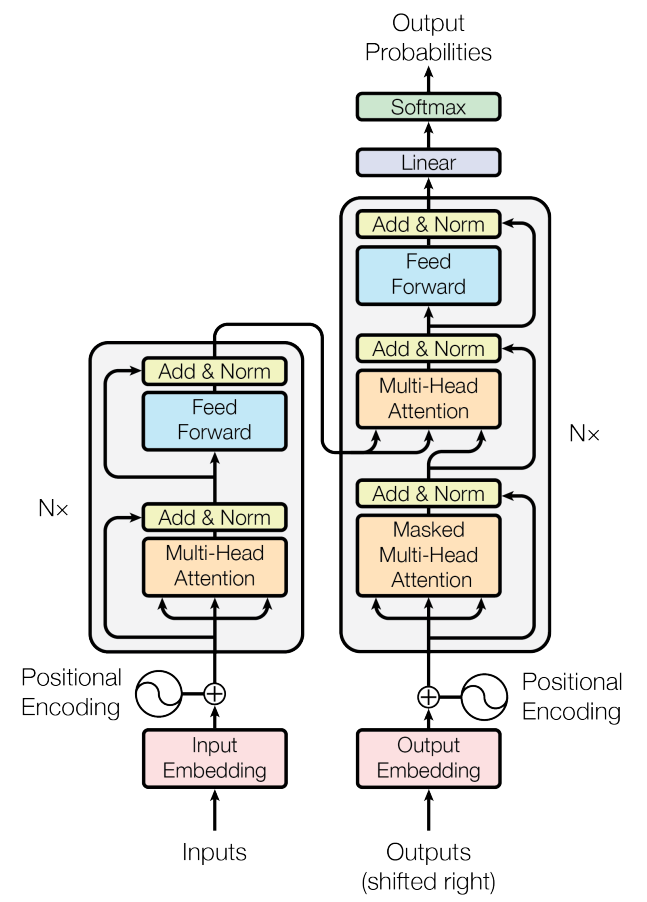

Next steps? Read this code: https://github.com/karpathy/minGPT/ and this one: https://github.com/karpathy/nanoGPT
They have a lot more teeth than the current one.